In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import random
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install split-folders
import splitfolders

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

print(f"TensorFlow version: {tf.__version__}")

--2023-12-23 09:17:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-12-23 09:17:10 (11.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]

TensorFlow version: 2.15.0


In [3]:
!nvidia-smi

Sat Dec 23 09:17:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/Soil dataset/Soil.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="/content/drive/MyDrive/Soil dataset")

In [5]:
path = "/content/drive/MyDrive/Soil dataset/Soil"
print(os.listdir(path))

['Mitha pani ki zameen', 'MIX', 'Kahra zameen']


In [ ]:
input_folder = '/content/drive/MyDrive/Soil dataset/Soil'

splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Soil dataset/Soil_Splitted",
                   seed=42, ratio=(.7, .0, .3),
                   group_prefix=None)


Copying files: 0 files [00:00, ? files/s]
Copying files: 2 files [00:00,  2.88 files/s]
Copying files: 3 files [00:01,  2.09 files/s]
Copying files: 4 files [00:02,  1.77 files/s]
Copying files: 5 files [00:02,  1.89 files/s]
Copying files: 6 files [00:03,  1.75 files/s]
Copying files: 7 files [00:03,  1.65 files/s]
Copying files: 8 files [00:04,  1.74 files/s]
Copying files: 9 files [00:04,  1.70 files/s]
Copying files: 10 files [00:05,  1.56 files/s]
Copying files: 11 files [00:06,  1.58 files/s]
Copying files: 12 files [00:07,  1.56 files/s]
Copying files: 13 files [00:08,  1.31 files/s]
Copying files: 14 files [00:09,  1.06 files/s]
Copying files: 15 files [00:10,  1.17 files/s]
Copying files: 16 files [00:10,  1.20 files/s]
Copying files: 17 files [00:11,  1.40 files/s]
Copying files: 18 files [00:12,  1.40 files/s]
Copying files: 19 files [00:12,  1.47 files/s]
Copying files: 20 files [00:13,  1.64 files/s]
Copying files: 21 files [00:13,  1.66 files/s]
Copying files: 22 files [

In [ ]:
walk_through_dir("/content/drive/MyDrive/Soil dataset/Soil_Splitted/")

There are 3 directories and 0 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/train'.
There are 0 directories and 38 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/train/Mitha pani ki zameen'.
There are 0 directories and 58 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/train/MIX'.
There are 0 directories and 30 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/train/Kahra zameen'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/val'.
There are 0 directories and 0 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/val/Mitha pani ki zameen'.
There are 0 directories and 0 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/val/MIX'.
There are 0 directories and 0 images in '/content/drive/MyDrive/Soil dataset/Soil_Splitted/val/Kahra zameen'.
There are 3 directories and 0 images in '/c

In [6]:
path = '/content/drive/MyDrive/Soil dataset/Soil'
print(os.listdir(path))

['Mitha pani ki zameen', 'MIX', 'Kahra zameen']


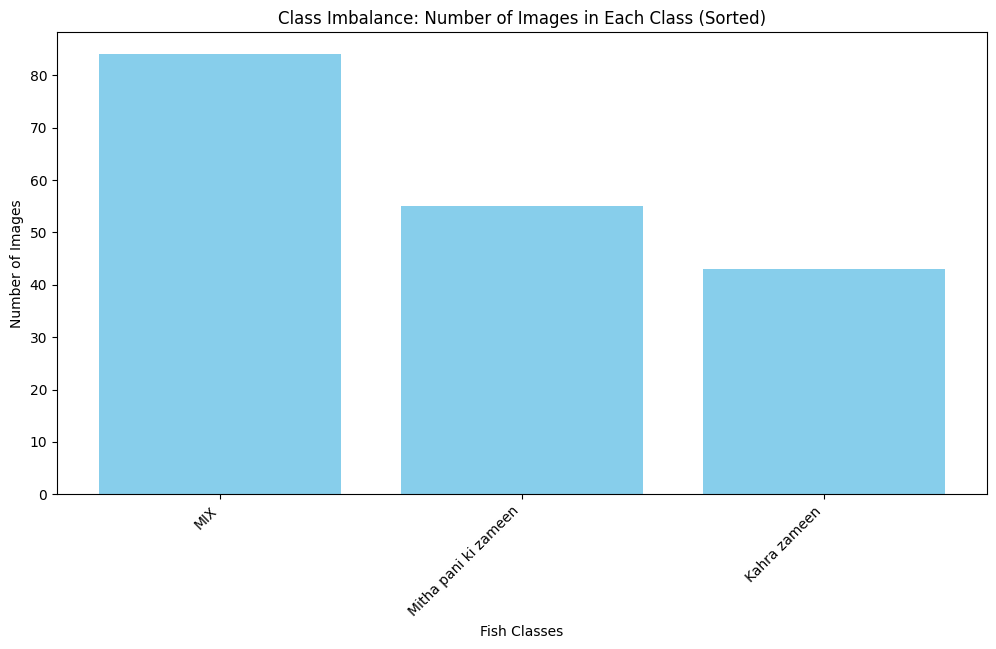

In [7]:
# Get the list of class folders
class_folders = os.listdir(path)

# Dictionary to store the count of images in each class
class_image_counts = {}

# Iterate through each class folder
for class_folder in class_folders:
    class_path = os.path.join(path, class_folder)

    # Count the number of images in the class folder
    num_images = len(os.listdir(class_path))

    # Store the count in the dictionary
    class_image_counts[class_folder] = num_images

# Sort the dictionary items by value in descending order
sorted_class_image_counts = dict(sorted(class_image_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting the bar graph
plt.figure(figsize=(12, 6))
plt.bar(sorted_class_image_counts.keys(), sorted_class_image_counts.values(), color='skyblue')
plt.xlabel('Fish Classes')
plt.ylabel('Number of Images')
plt.title('Class Imbalance: Number of Images in Each Class (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [8]:
sorted_class_image_counts

{'MIX': 84, 'Mitha pani ki zameen': 55, 'Kahra zameen': 43}

In [ ]:
total_images = sum(class_image_counts.values())
total_classes = len(class_image_counts)
average_images_per_class = total_images / total_classes

print(f"Total Images: {total_images}")
print(f"Total Classes: {total_classes}")
print(f"Average Images per Class: {average_images_per_class:.2f}")

minority_class_names = []
# Print classes with fewer images than the average
print("Classes with fewer images than the average:")
for class_name, image_count in class_image_counts.items():
    if image_count < average_images_per_class:
        print(f"{class_name}: {image_count} images")
        minority_class_names.append(class_name)

Total Images: 182
Total Classes: 3
Average Images per Class: 60.67
Classes with fewer images than the average:
Mitha pani ki zameen: 55 images
Kahra zameen: 43 images


In [ ]:
majority_class_names = []
for class_name, image_count in class_image_counts.items():
    if image_count > 100:
        print(f"{class_name}: {image_count} images")
        majority_class_names.append(class_name)

In [ ]:
minority_class_names

['Mitha pani ki zameen', 'Kahra zameen']

In [ ]:
majority_class_names

[]

In [ ]:
pip install pillow

In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 20.0 MB/s eta 0:00:00


In [ ]:
pip install heic-to-jpg

In [ ]:
from PIL import Image
import os
from pyheif import read

def convert_heic_to_png(heic_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through test, train, and val folders
    for split_folder in ['test', 'train', 'val']:
        split_folder_path = os.path.join(heic_folder, split_folder)

        # Ensure the split folder exists
        if os.path.exists(split_folder_path):
            # Iterate through subfolders (Kahra zameen, MIX, Mitha pani ki zameen)
            for subfolder in os.listdir(split_folder_path):
                subfolder_path = os.path.join(split_folder_path, subfolder)

                # Ensure the subfolder is a directory
                if os.path.isdir(subfolder_path):
                    # Iterate through each file in the subfolder
                    for root, dirs, files in os.walk(subfolder_path):
                        for file in files:
                            if file.lower().endswith('.heic'):
                                heic_path = os.path.join(root, file)

                                # Create subfolders in the output folder
                                output_subfolder = os.path.join(output_folder, split_folder, subfolder)
                                if not os.path.exists(output_subfolder):
                                    os.makedirs(output_subfolder)

                                # Convert HEIC to PNG using Pillow
                                png_path = os.path.join(output_subfolder, os.path.splitext(file)[0] + '.JPG')
                                heif_file = read(heic_path)
                                image = Image.frombytes(
                                    heif_file.mode,
                                    heif_file.size,
                                    heif_file.data,
                                    "raw",
                                    heif_file.mode,
                                    heif_file.stride,
                                )
                                image.save(png_path)

                                print(f"Converted {heic_path} to {png_path}")

# Provide the paths to your HEIC and output folders
heic_folder_path = '/content/drive/MyDrive/Soil dataset/Soil_Splitted'
output_folder_path = '/content/drive/MyDrive/Soil dataset/JPG Soil dataset'

# Call the function to convert HEIC to PNG
convert_heic_to_png(heic_folder_path, output_folder_path)

Converted /content/drive/MyDrive/Soil dataset/Soil_Splitted/test/Mitha pani ki zameen/IMG_2200.heic to /content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Mitha pani ki zameen/IMG_2200.JPG
Converted /content/drive/MyDrive/Soil dataset/Soil_Splitted/test/Mitha pani ki zameen/IMG_2187.heic to /content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Mitha pani ki zameen/IMG_2187.JPG
Converted /content/drive/MyDrive/Soil dataset/Soil_Splitted/test/Mitha pani ki zameen/IMG_2220.heic to /content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Mitha pani ki zameen/IMG_2220.JPG
Converted /content/drive/MyDrive/Soil dataset/Soil_Splitted/test/Mitha pani ki zameen/IMG_2190.heic to /content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Mitha pani ki zameen/IMG_2190.JPG
Converted /content/drive/MyDrive/Soil dataset/Soil_Splitted/test/Mitha pani ki zameen/IMG_2181.heic to /content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Mitha pani ki zameen/IMG_2181.JPG
Converted /content/drive/

In [9]:
train_dir = "/content/drive/MyDrive/Soil dataset/JPG Soil dataset/train/"
test_dir = "/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/"

In [10]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 125 files belonging to 3 classes.
Found 55 files belonging to 3 classes.


In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/content/drive/MyDrive/Soil dataset/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [21]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [22]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                             

In [27]:
#Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

#Fit
history_all_classes = model.fit(train_data, epochs=5) # fit for 5 epochs to keep experiments quick

Epoch 1/5
4/4 [==============================] - 18s 1s/step - loss: 0.3845 - accuracy: 0.9120
Epoch 2/5
4/4 [==============================] - 11s 640ms/step - loss: 0.3748 - accuracy: 0.9200
Epoch 3/5
4/4 [==============================] - 10s 881ms/step - loss: 0.3000 - accuracy: 0.9520
Epoch 4/5
4/4 [==============================] - 11s 593ms/step - loss: 0.2768 - accuracy: 0.9280
Epoch 5/5
4/4 [==============================] - 12s 577ms/step - loss: 0.2448 - accuracy: 0.9440


In [28]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

2/2 [==============================] - 26s 10s/step - loss: 0.2653 - accuracy: 0.8727


[0.26529309153556824, 0.8727272748947144]

In [29]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [30]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [31]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [32]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [34]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs, # validate on 15% of the test data
                                                     initial_epoch=history_all_classes.epoch[-1]) # start from previous last epoch

Epoch 5/10
4/4 [==============================] - 12s 931ms/step - loss: 0.1906 - accuracy: 0.9680
Epoch 6/10
4/4 [==============================] - 12s 760ms/step - loss: 0.1608 - accuracy: 0.9680
Epoch 7/10
4/4 [==============================] - 9s 674ms/step - loss: 0.1404 - accuracy: 0.9680
Epoch 8/10
4/4 [==============================] - 11s 578ms/step - loss: 0.1106 - accuracy: 0.9920
Epoch 9/10
4/4 [==============================] - 12s 880ms/step - loss: 0.0990 - accuracy: 0.9920
Epoch 10/10
4/4 [==============================] - 11s 564ms/step - loss: 0.0828 - accuracy: 0.9840


In [35]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_fine_tune = model.evaluate(test_data)
results_all_classes_fine_tune

2/2 [==============================] - 6s 2s/step - loss: 0.0898 - accuracy: 1.0000


[0.08982126414775848, 1.0]

In [36]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

2/2 [==============================] - 3s 988ms/step - loss: 0.0898 - accuracy: 1.0000


(0.08982126414775848, 1.0)

In [37]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

2/2 [==============================] - 4s 879ms/step


In [38]:
# How many predictions are there?
len(pred_probs)

55

In [39]:
# What's the shape of our predictions?
pred_probs.shape

(55, 3)

In [40]:
# How do they look?
pred_probs[:10]

array([[9.9729782e-01, 2.5719458e-03, 1.3022717e-04],
       [9.9850345e-01, 1.2404243e-03, 2.5609799e-04],
       [9.0667140e-01, 8.5357234e-02, 7.9713538e-03],
       [6.7253184e-01, 3.1612220e-01, 1.1345913e-02],
       [5.3210497e-01, 4.5913365e-01, 8.7613799e-03],
       [5.4390526e-01, 4.4793493e-01, 8.1598079e-03],
       [9.5240921e-01, 4.6913393e-02, 6.7731133e-04],
       [9.5333087e-01, 4.2380676e-02, 4.2884387e-03],
       [9.8847735e-01, 1.0245517e-02, 1.2771642e-03],
       [9.9481380e-01, 4.6568387e-03, 5.2944943e-04]], dtype=float32)

In [41]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 3
What prediction probability sample 0 looks like:
 [9.9729782e-01 2.5719458e-03 1.3022717e-04]
The class with the highest predicted probability by the model for sample 0: 0


In [42]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

55

In [45]:
# Get accuracy score by comparing predicted classes to ground truth labels
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

1.0

In [46]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 0.0


In [47]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
from helper_functions import make_confusion_matrix

In [48]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [49]:
# Get the class names
class_names = test_data.class_names

In [50]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [51]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        16

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



In [52]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 26},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 55},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 55}}

In [53]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Kahra zameen': 1.0, 'MIX': 1.0, 'Mitha pani ki zameen': 1.0}

In [54]:
# Turn f1-scores into dataframe for visualization
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
0,Kahra zameen,1.0
1,MIX,1.0
2,Mitha pani ki zameen,1.0


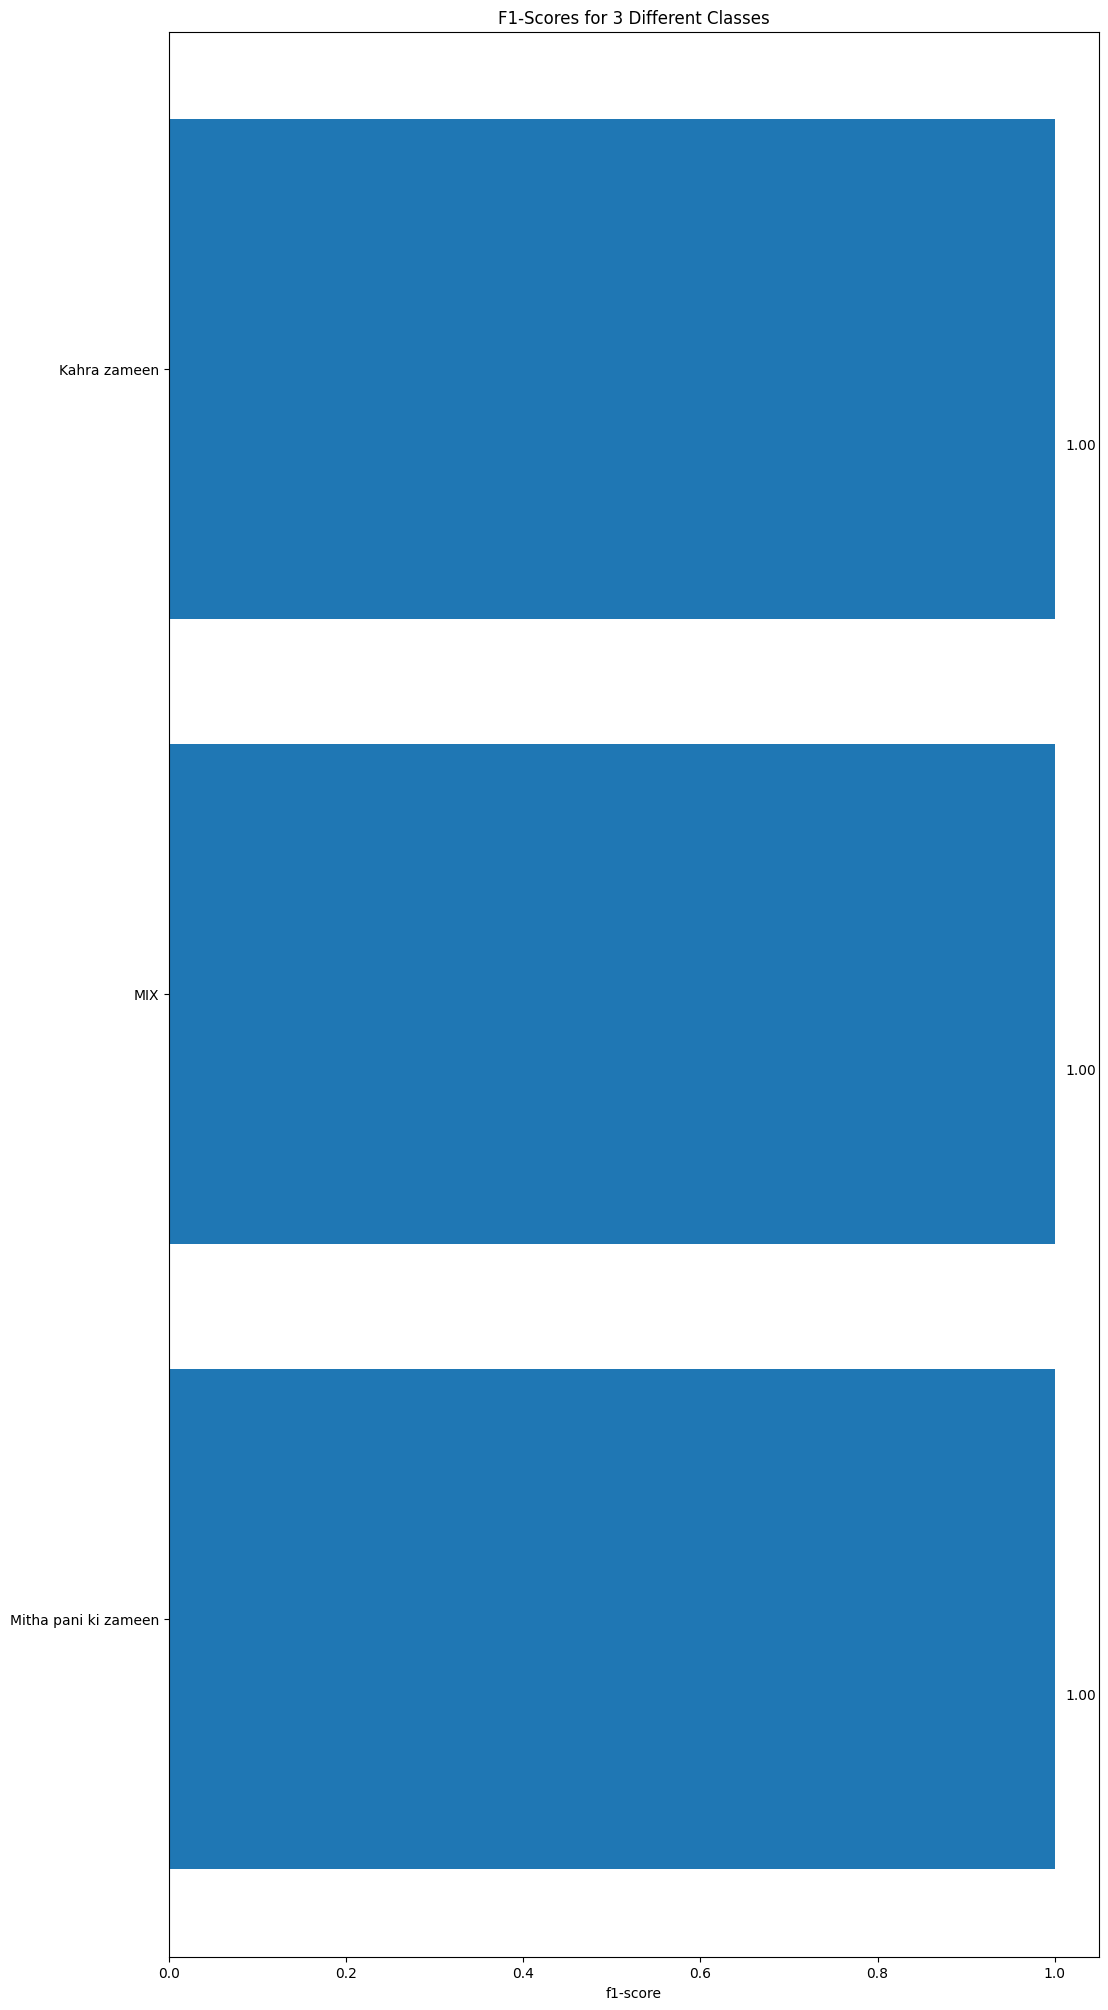

In [55]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 3 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [56]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [57]:
# Make preds on a series of random images
def make_preds(m):
  plt.figure(figsize=(17, 10))
  for i in range(3):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
    pred_prob = m.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

1/1 [==============================] - 0s 27ms/step


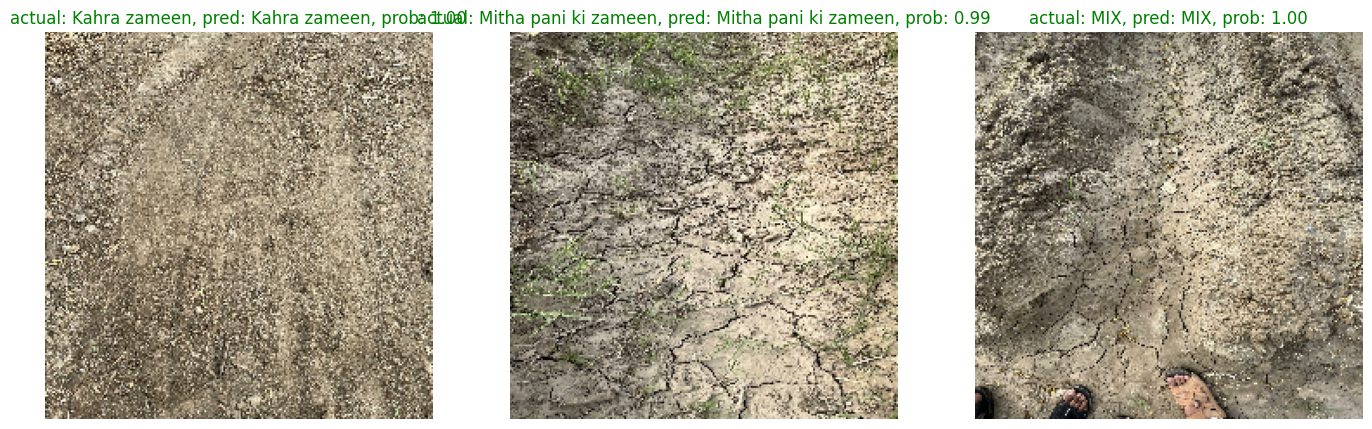

In [58]:
# Make preds on a series of random images
plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [59]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/*/*.JPG",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2228.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2229.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2230.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2233.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2234.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2235.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2236.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2242.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2243.JPG',
 b'/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/Kahra zameen/IMG_2245.JPG']

In [60]:
# 2. Create a dataframe out of current prediction data for analysis
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.997298,Kahra zameen,Kahra zameen
1,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.998503,Kahra zameen,Kahra zameen
2,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.906671,Kahra zameen,Kahra zameen
3,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.672532,Kahra zameen,Kahra zameen
4,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.532105,Kahra zameen,Kahra zameen


In [61]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.997298,Kahra zameen,Kahra zameen,True
1,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.998503,Kahra zameen,Kahra zameen,True
2,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.906671,Kahra zameen,Kahra zameen,True
3,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.672532,Kahra zameen,Kahra zameen,True
4,b'/content/drive/MyDrive/Soil dataset/JPG Soil...,0,0,0.532105,Kahra zameen,Kahra zameen,True


In [62]:
# 4. Get the top wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct


In [63]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

<Figure size 1500x1000 with 0 Axes>

In [64]:
# Define the directory where your images are located in Google Drive
image_directory = "/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX"

# List all image file paths in the specified directory
custom_food_images = [os.path.join(image_directory, img_path) for img_path in os.listdir(image_directory)]

# Print the list of image file paths
print(custom_food_images)


['/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2105.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2152.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2125.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2113.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2099.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2165.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2169.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2162.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2115.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2139.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2123.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/IMG_2142.JPG', '/content/drive/MyDrive/Soil dataset/JPG Soil dataset/test/MIX/

In [65]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Output hidden; open in https://colab.research.google.com to view.

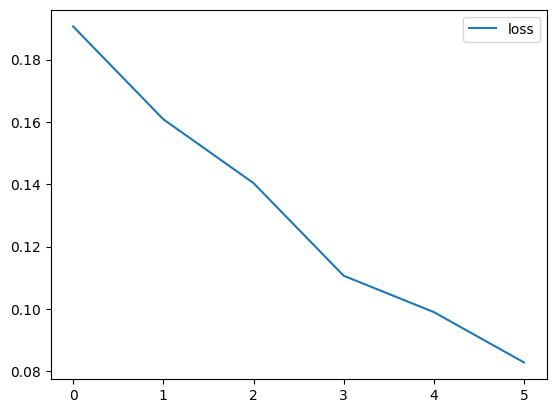

In [66]:
plt.plot(history_all_classes_fine_tune.history['loss'], label='loss')
#plt.plot(history_all_classes_fine_tune.history['val_loss'], label='val_loss')
plt.legend()

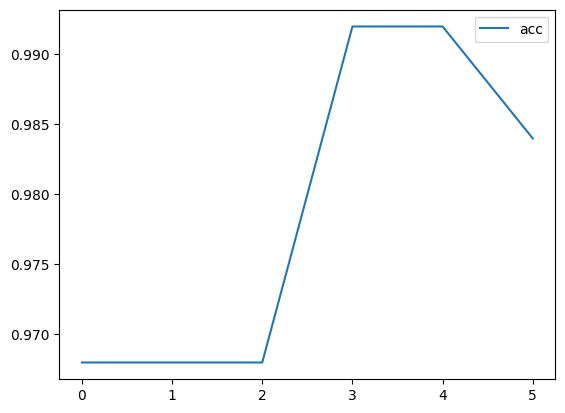

In [67]:
plt.plot(history_all_classes_fine_tune.history['accuracy'], label='acc')
#plt.plot(history_all_classes_fine_tune.history['val_accuracy'], label='val_acc')
plt.legend()

In [68]:
model_name = 'fyp_soil_model_fine_tuned.h5'
model.save(model_name, save_format='h5')
model.save_weights('fyp_soil_model_fine_tuned_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
loaded_model = load_model("fyp_soil_model_fine_tuned.h5")

In [70]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                             

1/1 [==============================] - 0s 48ms/step


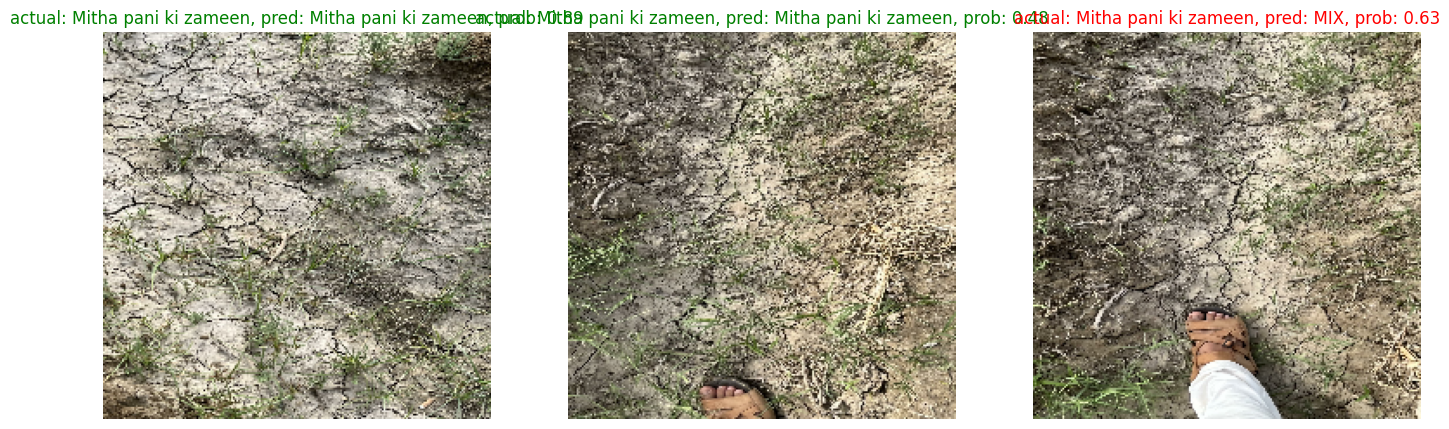

In [71]:
make_preds(loaded_model)